### **In the all_models_and_comparison notebook, I experimented with various models without explicitly addressing overfitting**

---

### **Importing the requited Libraries**

In [1]:
import pandas as pd
import numpy as np
import warnings
import joblib
import pickle
import seaborn as sns
from keras.layers import Dense
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from keras.models import Sequential
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scikeras.wrappers import KerasClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score,\
    recall_score, precision_score, confusion_matrix

### **Loading raw data, split  it, then process it**

In [2]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Load data
heart_data = pd.read_csv("../data/processed/heart_cleaned_data.csv")

# Define features and target
numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
target_variable = 'HeartDisease'

# Splitting the data
X = heart_data[numerical_features + categorical_features]
y = heart_data[target_variable]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=67)

# Preprocessing for numerical and categorical features
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

### **1 - Random Forest**

In [3]:
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=67)

# Create a pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", rf_classifier)])

# Define parameter grid for Random Forest
param_grid = {
    'classifier__n_estimators': [50, 100, 200],  # Number of trees
    'classifier__max_depth': [None, 10, 20, 30],  # Maximum depth of trees
    'classifier__min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'classifier__min_samples_leaf': [1, 2, 4],    # Minimum samples required at leaf node
}

# Grid search for best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', return_train_score=True)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best Parameters Found:")
print(grid_search.best_params_)

# Best model based on grid search
best_rf_model = grid_search.best_estimator_


y_pred = best_rf_model.predict(X_test)

# Test accuracy on the best model
test_accuracy = accuracy_score(y_test, best_rf_model.predict(X_test))
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate precision and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Calculate AUC for the best model
y_pred_prob = best_rf_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC Score: {auc_score:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve with both AUC and Accuracy in the legend
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.4f}, Accuracy = {test_accuracy:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.title("Random Forest: ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.savefig("../reports/overfitting_not_addresses/Random Forest_ROC Curve.png")
plt.grid(True)
plt.show()


# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])
plt.title("Random Forest : Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig("../reports/overfitting_not_addresses/Random Forest_Confusion Matrix.png")
plt.show()


# Bar plot for Accuracy, Precision, and Recall
metrics = [test_accuracy, precision, recall]
metric_names = ['Accuracy', 'Precision', 'Recall']

plt.figure(figsize=(8, 6))
plt.barh(metric_names, metrics, color=['green', 'orange', 'skyblue'])
plt.title('Accuracy, Recall, and Precision')
plt.xlabel('Random Forest : Scores')
plt.savefig("../reports/overfitting_not_addresses/Random Forest_Scores.png")

plt.show()

  

KeyboardInterrupt: 

---

### **2 - Logistic Regression**

Best Parameters Found:
{'classifier__C': 0.23357214690901212, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Test Accuracy: 0.9076
Precision: 0.9271
Recall: 0.8990
AUC Score: 0.9697


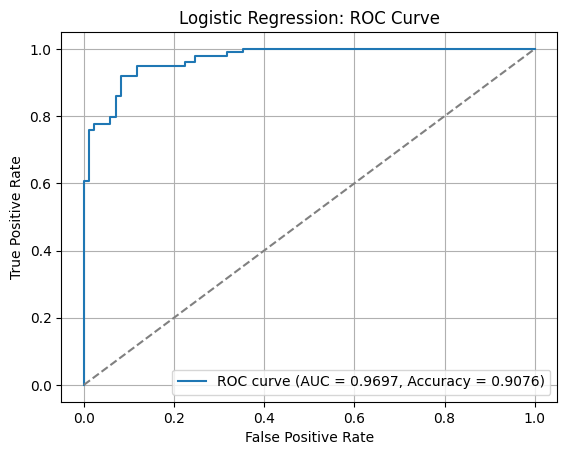

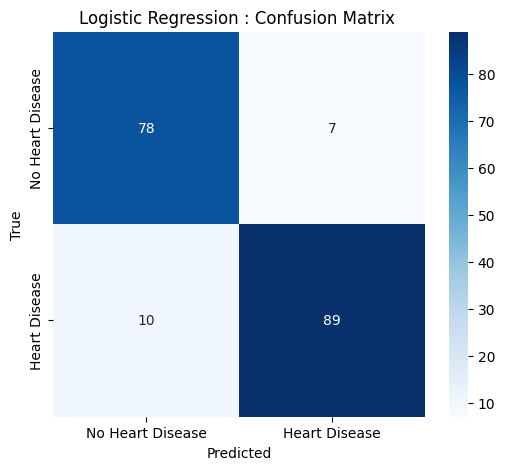

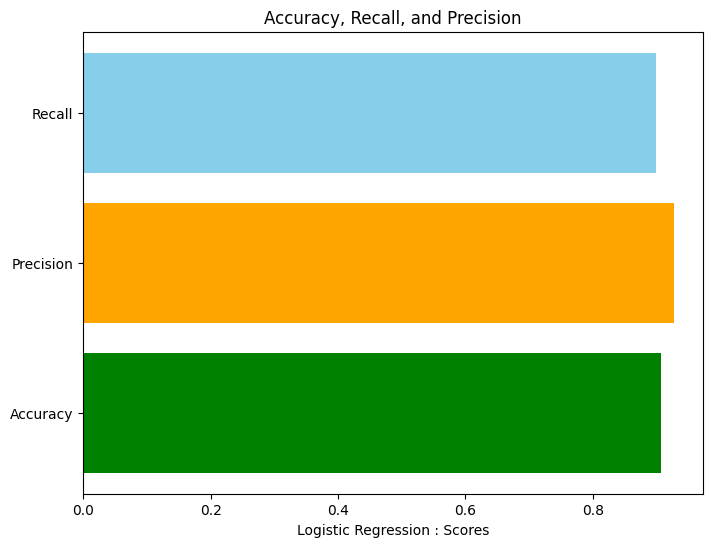

FileNotFoundError: [Errno 2] No such file or directory: '../models/overfitting_not_addresses/best_logreg_model.pkl'

In [4]:

# Create a Logistic Regression classifier
logreg = LogisticRegression(max_iter=1000)

# Create a pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", logreg)])

# Define parameter grid for Logistic Regression
param_grid = {
    'classifier__C': np.logspace(-4, 4, 20),  # Regularization strength (inverse of C)
    'classifier__penalty': ['l2'],  # Regularization type
    'classifier__solver': ['liblinear', 'saga'],  # Solvers for optimization
}

# Grid search for best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', return_train_score=True)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best Parameters Found:")
print(grid_search.best_params_)

# Best model based on grid search
best_logreg_model = grid_search.best_estimator_

y_pred = best_logreg_model.predict(X_test)


# Test accuracy on the best model
test_accuracy = accuracy_score(y_test, best_logreg_model.predict(X_test))
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate precision and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Calculate AUC for the best model
y_pred_prob = best_logreg_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC Score: {auc_score:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve with both AUC and Accuracy in the legend
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.4f}, Accuracy = {test_accuracy:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.title("Logistic Regression: ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("../reports/overfitting_not_addresses/Logistic Regression_ROC Curve.png")
plt.show()



# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])
plt.title("Logistic Regression : Confusion Matrix ")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig("../reports/overfitting_not_addresses/Logistic Regression_Confusion Matrix.png")
plt.show()


# Bar plot for Accuracy, Precision, and Recall
metrics = [test_accuracy, precision, recall]
metric_names = ['Accuracy', 'Precision', 'Recall']

plt.figure(figsize=(8, 6))
plt.barh(metric_names, metrics, color=['green', 'orange', 'skyblue'])
plt.title('Accuracy, Recall, and Precision')
plt.xlabel('Logistic Regression : Scores')
plt.savefig("../reports/Logistic Regression_Scores.png")
plt.show()

# Save the best model using pickle   
    

with open('../models/overfitting_not_addresses/best_logreg_model.pkl', 'wb') as file:
    joblib.dump(best_logreg_model, file)
    print("Best model saved as 'best_logreg_model.pkl'")
    
  

---

### **3 - KNN**

In [ ]:
# Create a KNN classifier
knn = KNeighborsClassifier()

# Create a pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", knn)])

# Define parameter grid for KNN classifier
param_grid = {
    'classifier__n_neighbors': np.arange(2, 50, 2),  # Varying n_neighbors
    'classifier__weights': ['uniform', 'distance'],  # Varying the weights
    'classifier__metric': ['euclidean', 'manhattan'],  # Different distance metrics
}

# Grid search for best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', return_train_score=True)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best Parameters Found:")
print(grid_search.best_params_)

# Best model based on grid search
best_knn_model = grid_search.best_estimator_

# Test predictions
y_pred = best_knn_model.predict(X_test)

# Test accuracy on the best model
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate precision and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Calculate AUC for the best model
y_pred_prob = best_knn_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC Score: {auc_score:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve with both AUC and Accuracy in the legend
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.4f}, Accuracy = {test_accuracy:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.title("KNN: ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("../reports/overfitting_not_addresses/KNN_ROC Curve.png")
plt.show()

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])
plt.title("KNN - Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig("../reports/overfitting_not_addresses/KNN_Confusion Matrix.png")
plt.show()


# Bar plot for Accuracy, Precision, and Recall
metrics = [test_accuracy, precision, recall]
metric_names = ['Accuracy', 'Precision', 'Recall']

plt.figure(figsize=(8, 6))
plt.barh(metric_names, metrics, color=['green', 'orange', 'skyblue'])
plt.title('Accuracy, Recall, and Precision')
plt.xlabel('KNN : Scores')
plt.savefig("../reports/overfitting_not_addresses/KNN_Scores.png")
plt.show()


    

---

### **4 - NEURAL NETWORK**

In [ ]:
#To get the correct number of input features after one-hot encoding
X_train_transformed = preprocessor.fit_transform(X_train)
input_dim = X_train_transformed.shape[1]  # Number of features after preprocessing

# Function to create the Sequential model
def create_nn_model(hidden_layer_sizes=(128,)):
    model = Sequential()
    # Add input layer (with number of features as input_dim)
    model.add(Dense(64, input_dim=input_dim, activation='relu'))  # First hidden layer
    for units in hidden_layer_sizes:
        model.add(Dense(units, activation='relu'))  # Additional hidden layers
    model.add(Dense(1, activation='sigmoid'))  # Output layer (binary classification)
    
    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Create a KerasClassifier wrapper for the neural network
nn_classifier = KerasClassifier(build_fn=create_nn_model, epochs=50, batch_size=32, verbose=0)

# Create a pipeline
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", nn_classifier)])

# Define parameter grid for Neural Network
param_grid = {
    'classifier__epochs': [50, 100],  # Number of epochs for training
    'classifier__batch_size': [16, 32],  # Batch sizes
}

# Grid search for best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', return_train_score=True)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best Parameters Found:")
print(grid_search.best_params_)

# Best model based on grid search
best_nn_model = grid_search.best_estimator_


y_pred = best_nn_model.predict(X_test)


# Test accuracy on the best model
test_accuracy = accuracy_score(y_test, best_nn_model.predict(X_test))
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate precision and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


# Calculate AUC for the best model
y_pred_prob = best_nn_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC Score: {auc_score:.4f}")

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

# Plot the ROC curve with both AUC and Accuracy in the legend
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc_score:.4f}, Accuracy = {test_accuracy:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.title("Neural Network: ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig("../reports/overfitting_not_addresses/Neural Network_ROC Curve.png")

plt.show()


# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Heart Disease', 'Heart Disease'], yticklabels=['No Heart Disease', 'Heart Disease'])
plt.title("Neural Network : Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig("../reports/overfitting_not_addresses/Neural Network_Confusion Matrix.png")
plt.show()


# Bar plot for Accuracy, Precision, and Recall
metrics = [test_accuracy, precision, recall]
metric_names = ['Accuracy', 'Precision', 'Recall']

plt.figure(figsize=(8, 6))
plt.barh(metric_names, metrics, color=['green', 'orange', 'skyblue'])
plt.title('Accuracy, Recall, and Precision')
plt.xlabel('Neural Network : Scores')
plt.savefig("../reports/overfitting_not_addresses/Neural Network_Scores.png")
plt.show()

    

